In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import math

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import *
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from keras import callbacks
from keras import ops
from keras import layers
from keras import optimizers
import keras_tuner
from tensorflow_probability import distributions as tfd
from scipy.stats import linregress
from molmass import Formula


from scipy.special import erf, erfinv
from matplotlib.colors import Normalize
from matplotlib import colors
from matplotlib import cm
import itertools
from scipy.stats import entropy
from scipy.interpolate import interpn

from support import *
MASS_H2 = Formula('H2').mass





Using TensorFlow backend


In [13]:
mg=2*1.0079*0.001/(6.022e23) #[kg]
mu=mg/4
b_l=0.741e-10 #[m]
I=mu*(b_l**2)
conv_omega=1.0e12 #convert [1/ps] to [1/s]
conv_J_2_eV=6.24e18
# omega_SI=vel[:,6:10]*conv_omega
# rot_energy_in=0.5*I*(omega_SI[:,0]*2+omega_SI[:,1]*2)
# rot_energy_out=0.5*I*(omega_SI[:,2]*2+omega_SI[:,-1]*2)

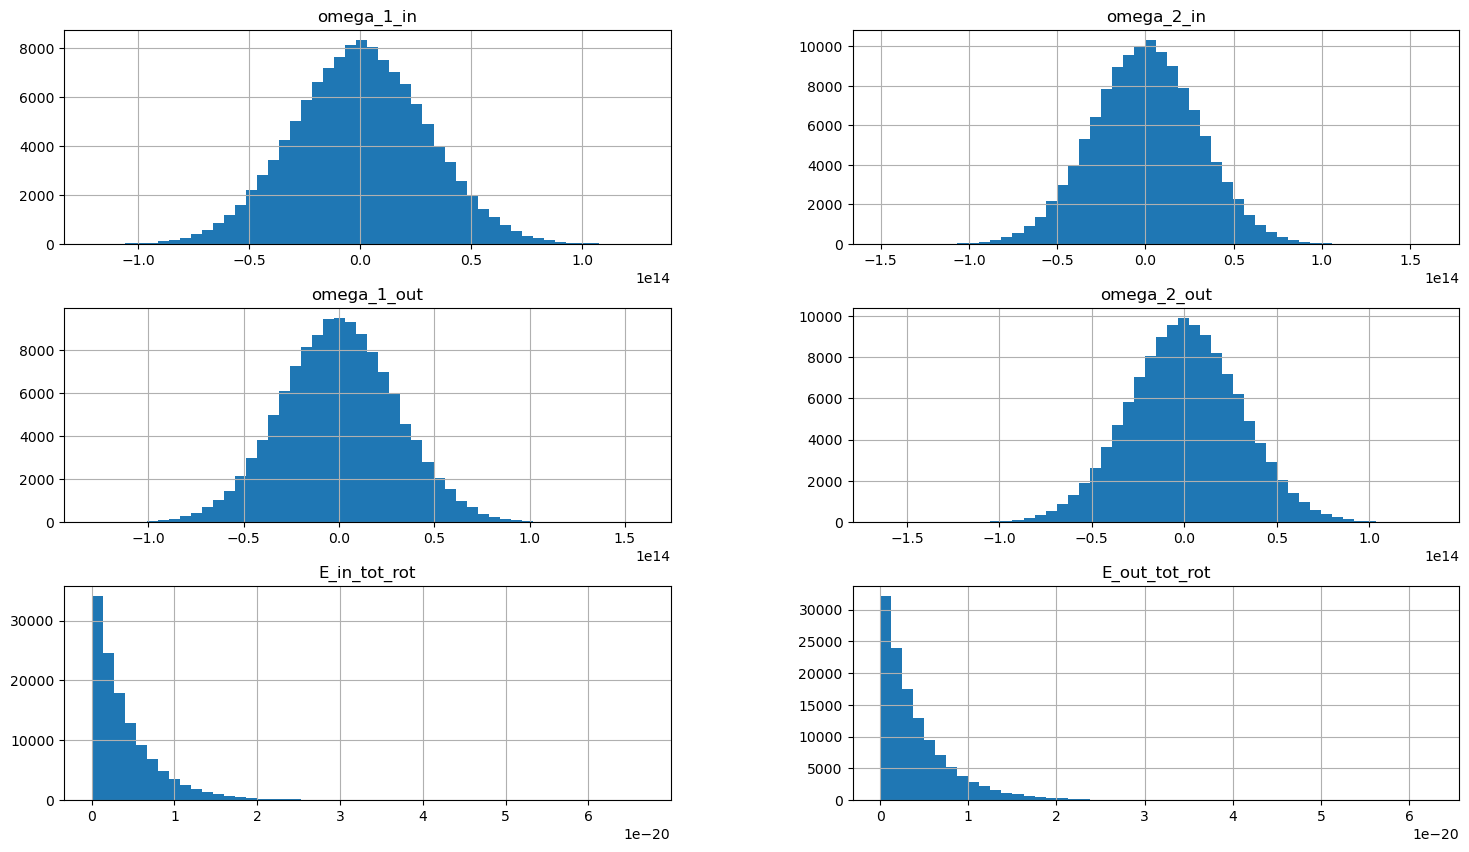

In [23]:
filename = r'D:\OneDrive - TU Eindhoven\Quartile_4\4AI000_Machine learning for Multi-physics modelling and design\Materials_for_ML_assignment_2024\H2_IsoThermalWalls_Sw_0\H2_omega_Sw_0_B300_Th_300.txt'
names_rot_vel = ['omega_1_in', 'omega_2_in', 'omega_1_out', 'omega_2_out']
df_rot_vel = pd.read_csv(filename, sep= '\s+', header=None, skiprows=[0], names = names_rot_vel).sample(frac = 1)

df_rot_vel = df_rot_vel*conv_omega
df_rot_vel['E_in_tot_rot'] = 0.5*I*(np.power(df_rot_vel['omega_1_in'],2)+np.power(df_rot_vel['omega_2_in'],2))
df_rot_vel['E_out_tot_rot'] = 0.5*I*(np.power(df_rot_vel['omega_1_out'],2)+np.power(df_rot_vel['omega_2_out'],2))

# Plot histogram for each feature
df_rot_vel.hist(bins = 50, layout= (3,2), figsize= (18,10))

x = df_rot_vel.loc[:, ].values

scaler = MinMaxScaler()
min_max_values = scaler.fit(x)
x_norm = scaler.fit_transform(x) 

# Create dataframe with normalized values
names_rot_vel_norm = ['omega_1_in', 'omega_2_in', 'omega_1_out', 'omega_2_out', 'E_in_tot_rot','E_out_tot_rot' ]
df_rot_vel_norm = pd.DataFrame(x_norm,columns=names_rot_vel_norm)

# Select the features to train MDN
x = df_rot_vel_norm[['omega_1_in', 'omega_2_in']].to_numpy()
y = df_rot_vel_norm[['omega_1_out', 'omega_2_out']].to_numpy()


### Selected components 

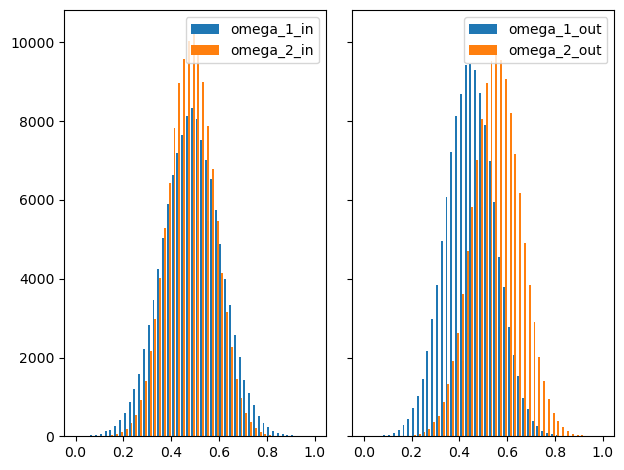

In [18]:
n_bins = 50

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(x, bins=n_bins, label = ['omega_1_in', 'omega_2_in'])
axs[1].hist(y, bins=n_bins, label = ['omega_1_out', 'omega_2_out'])
axs[0].legend()
axs[1].legend()
plt.show()

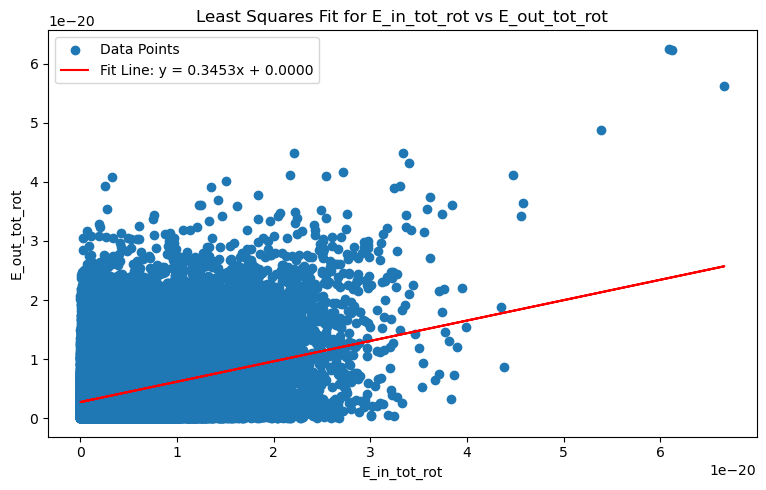

Slope, Intercept and AC for E_in_tot_rot vs E_out_tot_rot: Slope = 0.3453028805459896, Intercept = 2.7150852052686263e-21, AC = 0.6546971194540103


In [25]:
# List of column pairs to fit and plot
cols_pairs = [
    ('E_in_tot_rot', 'E_out_tot_rot')
    # Add more pairs as required
]

# Contour plots for all specified pairs
calculate_AC_scatter(df_rot_vel, cols_pairs)

#### Make train, test and validation split

In [8]:
# Test, train and validation split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=2)

# Reshaping the inputs and output tensors
x_1 = X_train[:,0].reshape((len(X_train[:]),1))
x_2 = X_train[:,1].reshape((len(X_train[:]),1))
y_1 = y_train[:,0].reshape((len(y_train[:]),1))
y_2 = y_train[:,1].reshape((len(y_train[:]),1))

x_1_val = X_val[:,0].reshape((len(X_val[:]),1))
x_2_val = X_val[:,1].reshape((len(X_val[:]),1))
y_1_val = y_val[:,0].reshape((len(y_val[:]),1))
y_2_val = y_val[:,1].reshape((len(y_val[:]),1))

x_1_test = X_test[:,0].reshape((len(X_test[:]),1))
x_2_test = X_test[:,1].reshape((len(X_test[:]),1))
y_1_test = y_test[:,0].reshape((len(y_test[:]),1))
y_2_test = y_test[:,1].reshape((len(y_test[:]),1))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 2)      │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 64)     │        192 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 64)     │      4,160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 64)     │      4,160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mixture_density_ou… │ (None, 1, 162)    │     10,530 │ dense_1[0][0]     │
│ (MixtureDensityOut… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mixture_density_ou… │ (None, 1, 162)    │     10,530 │ dense_2[0][0]     │
│ (MixtureDensityOut… │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,572 (115.52 KB)

 Trainable params: 29,572 (115.52 KB)

 Non-trainable params: 0 (0.00 B)

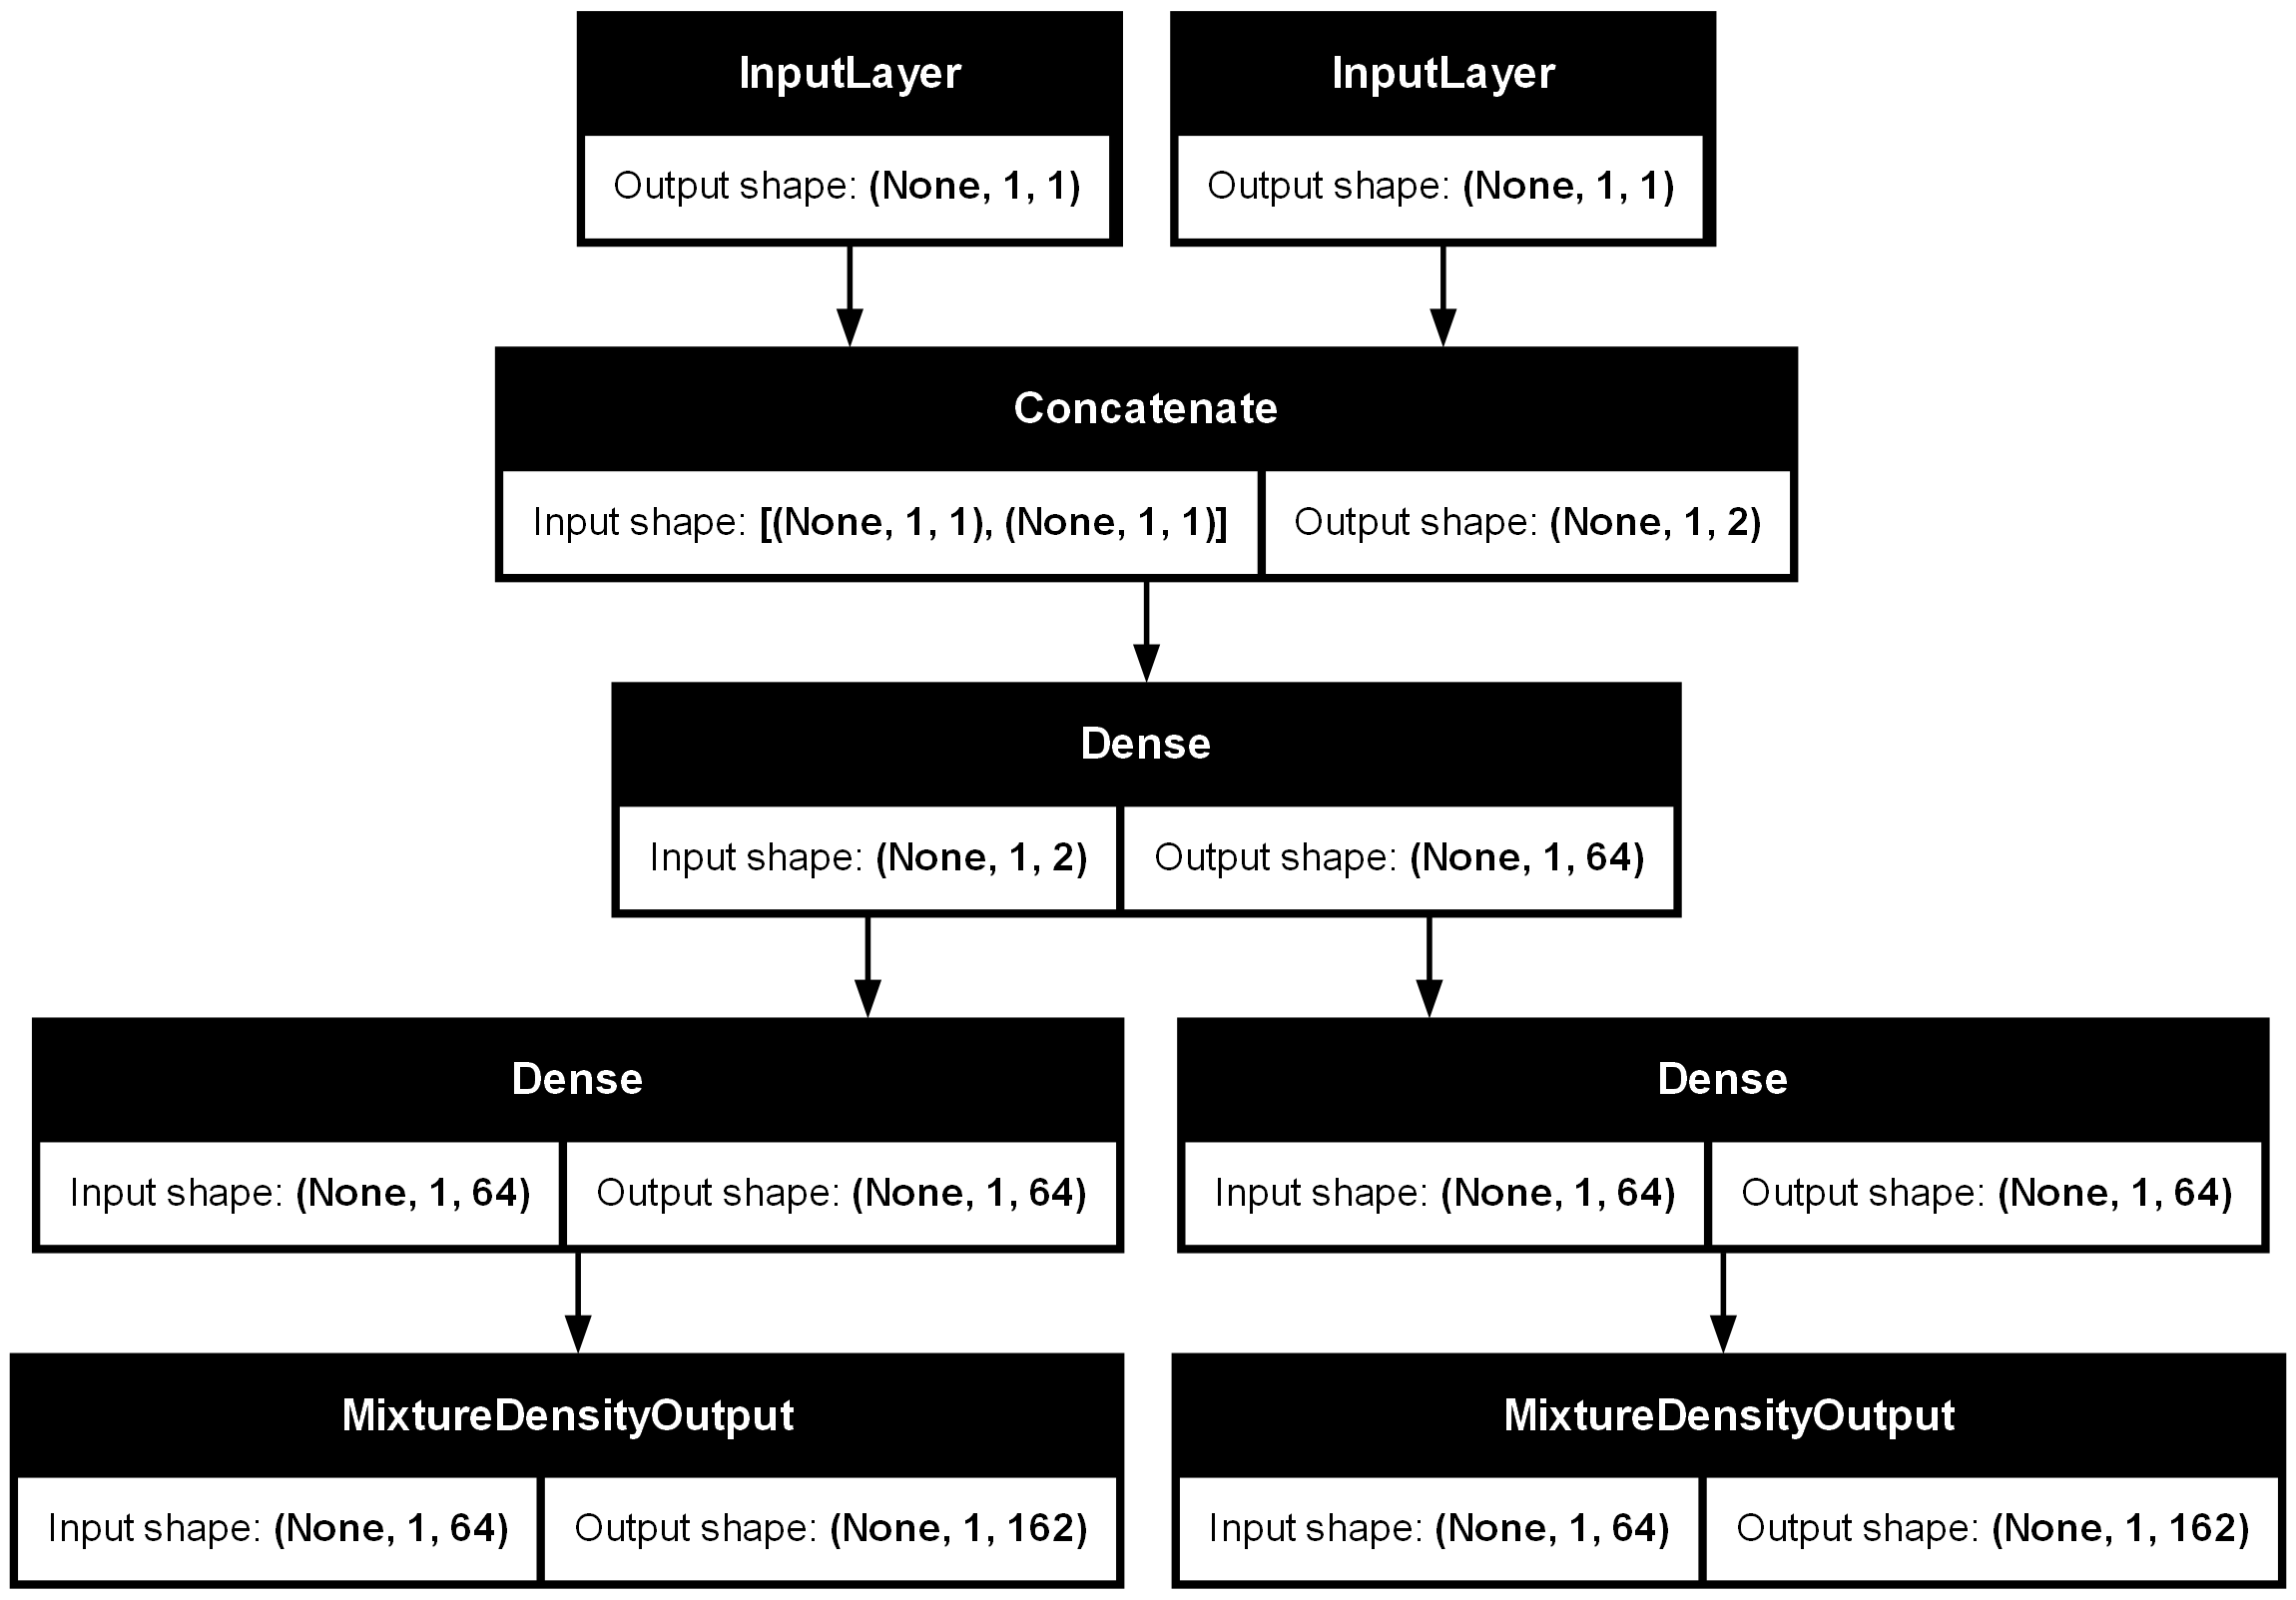

In [9]:
n_Units = 64
N_MIXES = 54
OUTPUT_DIMS = 1

lr = 0.001
loss_function = get_mixture_loss_func(OUTPUT_DIMS, N_MIXES)
optimizer = optimizers.Adam(learning_rate=lr)
activation = "relu"

def model(num_Mixes, n_Units, optimizer, loss_function):
    inputs1 = keras.Input(shape=(1, 1))
    inputs2 = keras.Input(shape=(1, 1))

    concat_layer = layers.concatenate([inputs1, inputs2])
    dense_layer = layers.Dense(units=n_Units, activation=activation)(concat_layer)

    x1 = layers.Dense(units=n_Units, activation= activation)(dense_layer)
    #x1 = layers.Dense(units=n_Units, activation=activation)(x1)
    block_1_output = MixtureDensityOutput(1, num_Mixes)(x1)

    x2 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    #x2 = layers.Dense(units=n_Units, activation=activation)(x2)
    block_2_output = MixtureDensityOutput(1, num_Mixes)(x2)


    # x3 = layers.Dense(units=n_Units, activation=activation)(dense_layer)
    # #x3 = layers.Dense(units=n_Units, activation=activation)(x3)
    # block_3_output = MixtureDensityOutput(1, num_Mixes)(x3)

    model = keras.Model(inputs=[inputs1, inputs2], outputs=[block_1_output,block_2_output])
    model.compile(
        optimizer=optimizer,
        loss= loss_function
        )
    return model

mdn_network = model(N_MIXES, n_Units, optimizer, loss_function)

mdn_network.summary()

keras.utils.plot_model(mdn_network, show_shapes=True)

# OLD MODEL 

# n_Units = 32
# N_MIXES = 40
# OUTPUT_DIMS = 1

# lr = 0.001
# loss_function = get_mixture_loss_func(OUTPUT_DIMS, N_MIXES)
# optimizer = optimizers.Adam(learning_rate=lr)
# activation = "relu"

# def model(num_Mixes, n_Units, optimizer, loss_function):
#     inputs1 = keras.Input(shape=(1, 1))
#     x1 = layers.Dense(units=n_Units, activation= activation)(inputs1)
#     x1 = layers.Dense(units=n_Units, activation= activation)(x1)
#     block_1_output = MixtureDensityOutput(1, num_Mixes)(x1)

#     inputs2 = keras.Input(shape=(1, 1))
#     x2 = layers.Dense(units=n_Units, activation= activation)(inputs2)
#     x2 = layers.Dense(units=n_Units, activation= activation)(x2)
#     block_2_output = MixtureDensityOutput(1, num_Mixes)(x2)

#     inputs3 = keras.Input(shape=(1, 1))
#     x3 = layers.Dense(units=n_Units, activation=activation)(inputs3)
#     x3 = layers.Dense(units=n_Units, activation=activation)(x3)
#     block_3_output = MixtureDensityOutput(1, num_Mixes)(x3)

#     model = keras.Model(inputs=[inputs1, inputs2, inputs3], outputs=[block_1_output,block_2_output, block_3_output])
#     model.compile(
#         optimizer=optimizer,
#         loss= loss_function
#         )
#     return model

# mdn_network = model(N_MIXES, n_Units, optimizer, loss_function)

# mdn_network.summary()

# keras.utils.plot_model(mdn_network, show_shapes=True)

In [10]:
epochs = 200

history = mdn_network.fit(
    [x_1, x_2],
    [y_1, y_2],
    epochs=epochs,
    batch_size = 128,
    validation_split=0.05,
    shuffle = True,
    callbacks=[
        callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="loss", patience=5),
    ],
)

Epoch 1/200
765/765 ━━━━━━━━━━━━━━━━━━━━ 95s 28ms/step - loss: -0.7700 - val_loss: -1.6023 - learning_rate: 0.0010
Epoch 2/200
765/765 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: -1.6238 - val_loss: -1.6083 - learning_rate: 0.0010
Epoch 3/200
765/765 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: -1.6380 - val_loss: -1.6258 - learning_rate: 0.0010
Epoch 4/200
765/765 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: -1.6375 - val_loss: -1.6283 - learning_rate: 0.0010
Epoch 5/200
765/765 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: -1.6430 - val_loss: -1.6167 - learning_rate: 0.0010
Epoch 6/200
765/765 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: -1.6358 - val_loss: -1.6247 - learning_rate: 0.0010
Epoch 7/200
765/765 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: -1.6368 - val_loss: -1.6288 - learning_rate: 0.0010
Epoch 8/200
765/765 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: -1.6363 - val_loss: -1.6240 - learning_rate: 0.0010
Epoch 9/200
765/765 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: -1.6352 - val_loss: -1.6

KeyboardInterrupt: 

### Hyperparameter tuning - Defining search space and type of optimization

In [37]:
def model(hp, num_Mixes = 20, num_Layers = 2, activation = "Relu", dropout = False, dropout_rate = 0.2, lr = 0.001, optimizer = ""):
    model =  keras.Sequential()
    
    for i in range(1, num_Layers+1):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=activation)
        )
        if dropout:
            model.add(layers.Dropout(dropout_rate))   
    
    model.add(MixtureDensityOutput(OUTPUT_DIMS, num_Mixes))

    if optimizer == 'Adam':
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer == 'AdamW':
        optimizer = optimizers.AdamW(learning_rate=lr)
    elif optimizer == 'Nadam':
        optimizer = optimizers.Nadam(learning_rate=lr)
    elif optimizer == 'Adadelta':
        optimizer = optimizers.Adadelta(learning_rate=lr)        
    else:
        optimizer = optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer = optimizer,
        loss= get_mixture_loss_func(OUTPUT_DIMS, num_Mixes),
    )
    return model

# Define hyper-parameter search space
def build_model(hp):

    # Choices for number of Mixtures - an important advantage of using MDN
    num_Mixes = hp.Int("num_Mixes", min_value=10, max_value=100, step=1)
    
    # Choices for number of layers
    num_Layers = hp.Int("num_layers", min_value=1, max_value=2, step=1)    # hp.Int("num_layers", min_value=1, max_value=10, step=1)

    # Choices of activation
    activation = hp.Choice("activation", ["relu", "leaky_relu"])      # ["relu", "tanh", "sigmoid", "leaky_relu", "elu"]
    
    # Choice on dropout
    dropout = hp.Boolean("dropout", default = True)

    # Choices on dropout rate
    dropout_rate = hp.Float("dropout_rate", min_value = 0.0, max_value = 0.5, step = 0.2)   # hp.Float ("dropout_rate", min_value = 0.05, max_value = 0.75, step = 0.02)

    # Choices on learning rate
    optimizer = hp.Choice("optimizer", ["Adam", "Nadam", "Adadelta"])  # ["Adam", "AdamW", "Nadam", "Adadelta"]
    
    # Call existing model-building code with the hyperparameter values.
    mdn_network = model(
        hp, num_Mixes=num_Mixes, 
        num_Layers=num_Layers, 
        activation=activation, 
        dropout_rate= dropout_rate, 
        dropout=dropout,  
        optimizer = optimizer
    )
    return mdn_network


build_model(keras_tuner.HyperParameters())

# Directory to store the models during hyper-parameter tuning 
directory = r"D:\OneDrive - TU Eindhoven\Quartile_4\4AI000_Machine learning for Multi-physics modelling and design\Materials_for_ML_assignment_2024\models"

tuner = keras_tuner.BayesianOptimization(
    hypermodel= build_model,
    max_trials= 40,
    objective = "loss",
    alpha=0.0001,
    beta=2.6,
    seed= 1,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=3,
    project_name="models_4AI000_rotation",
    overwrite = True,
)

tuner.search_space_summary()

Search space summary
Default search space size: 7
num_Mixes (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 1, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'leaky_relu'], 'ordered': False}
dropout (Boolean)
{'default': True, 'conditions': []}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.2, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'Nadam', 'Adadelta'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


### Perform hyper-parameter tuning

In [38]:
epochs = 10
# Split train and validation data
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.10, random_state=42)
tuner.search(X_train, y_train, epochs= epochs, validation_data=(X_val, y_val))

Trial 14 Complete [00h 18m 12s]
loss: -0.8086162805557251

Best loss So Far: -0.810815155506134
Total elapsed time: 01h 57m 25s

Search: Running Trial #15

Value             |Best Value So Far |Hyperparameter
53                |34                |num_Mixes
1                 |2                 |num_layers
relu              |relu              |activation
True              |False             |dropout
0.4               |0.4               |dropout_rate
Adam              |Adam              |optimizer
384               |416               |units_1
480               |96                |units_2

Epoch 1/10
5176/5176 ━━━━━━━━━━━━━━━━━━━━ 125s 11ms/step - loss: -0.6508 - val_loss: -0.8130
Epoch 2/10
5176/5176 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - loss: -0.7890 - val_loss: -0.8157
Epoch 3/10
5176/5176 ━━━━━━━━━━━━━━━━━━━━ 45s 9ms/step - loss: -0.8006 - val_loss: -0.8121
Epoch 4/10
5176/5176 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - loss: -0.8023 - val_loss: -0.8042
Epoch 5/10
5176/5176 ━━━━━━━━━━━━━━━━━━━━

#### Compile model with best hyper-parameters 

In [ ]:
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
mdn_network = build_model(best_hps[0])
print("The best hyper-parameters are")
print(best_hps[0].values)

#### Summary of best model

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
mdn_network_best = best_model
best_model.summary()

### Training the best model

In [ ]:
history = mdn_network_best.fit(
    x,
    y,
    epochs=100,
    batch_size = 512,
    validation_split=0.20,
    shuffle = True,
    callbacks=[
        callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="loss", patience=2),
    ],
)

### Plot the Loss

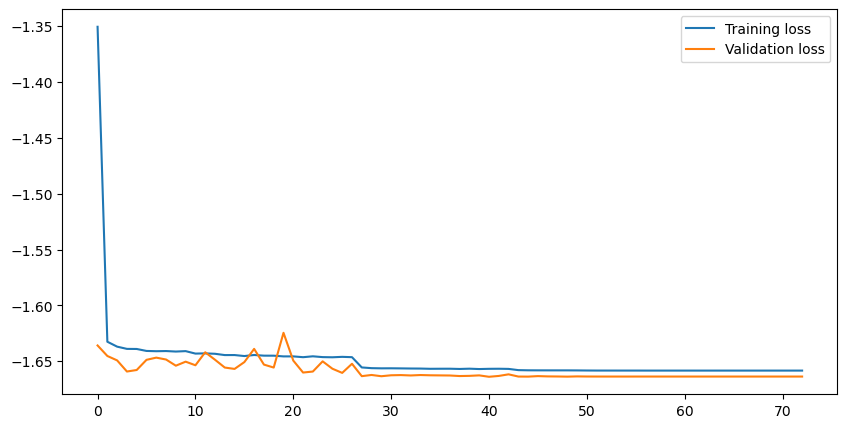

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

In [27]:
x_4_test = x_1_test
x_5_test = x_2_test
y_4_test = y_1_test
y_5_test = y_2_test

In [25]:

y_pred_mixture = mdn_network.predict((x_4_test,x_5_test))

1726/1726 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step


In [26]:
# Reshape and sampling
y_new = []
y_samples = []
for i in range(len(y_pred_mixture)):
    y_new.append(y_pred_mixture[i].reshape((len(y_pred_mixture[0]),N_MIXES*3)))
    y_samples.append(np.apply_along_axis(sample_from_output, 1, y_new[i], 1, N_MIXES, temp=1.0))
    y_samples[i] = y_samples[i].reshape((len(y_samples[i])))   

In [32]:
# Create data frame with results and original input/output velocities for plotting purpose

# Normalized dataframe that contains results - df_results_norm
# Renormalized df - df_results

df_results_norm = pd.DataFrame(y_samples).transpose()
df_results_norm.rename(columns = {0:'omega_1_out_pred', 1:'omega_2_out_pred'}, inplace = True)
df_results_norm['omega_1_in'] = x_4_test
df_results_norm['omega_2_in'] = x_5_test
df_results_norm['omega_1_out'] = y_4_test
df_results_norm['omega_2_out'] = y_5_test


df_results = pd.DataFrame([])
df_results['omega_1_in'] = re_normalize(df_results_norm['omega_1_in'], min_max_values.data_min_[0], min_max_values.data_max_[0])
df_results['omega_2_in'] = re_normalize(df_results_norm['omega_2_in'], min_max_values.data_min_[1], min_max_values.data_max_[1])
df_results['omega_1_out'] = re_normalize(df_results_norm['omega_1_out'], min_max_values.data_min_[2], min_max_values.data_max_[2])
df_results['omega_2_out'] = re_normalize(df_results_norm['omega_2_out'], min_max_values.data_min_[3], min_max_values.data_max_[3])
df_results['omega_1_out_pred'] = re_normalize(df_results_norm['omega_1_out_pred'], min_max_values.data_min_[2], min_max_values.data_max_[2])
df_results['omega_2_out_pred'] = re_normalize(df_results_norm['omega_2_out_pred'], min_max_values.data_min_[3], min_max_values.data_max_[3])

# # Creating columns for overall velocities
# df_results_norm['v_y_in_abs'] = np.absolute(df_results_norm["v_y_in"])
# df_results_norm['v_y_out_abs'] = np.absolute(df_results_norm["v_y_out"])
# df_results_norm['v_y_out_abs_pred'] = np.absolute(df_results_norm["v_y_out_pred"])
# df_results_norm['v_in_tot'] = (np.power(df_results_norm["v_x_in"],2)+ np.power(df_results_norm["v_y_in"],2) + np.power(df_results_norm["v_z_in"],2))**0.5
# df_results_norm['v_out_tot'] = (np.power(df_results_norm["v_x_out"],2)+ np.power(df_results_norm["v_y_out"],2) + np.power(df_results_norm["v_z_out"],2))**0.5
# df_results_norm['E_in_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_results_norm["v_x_in"],2)+ np.power(df_results_norm["v_y_in"],2) + np.power(df_results_norm["v_z_in"],2)))
# df_results_norm['E_out_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_results_norm["v_x_out"],2)+ np.power(df_results_norm["v_y_out"],2) + np.power(df_results_norm["v_z_out"],2)))
# df_results_norm['E_out_tot_trans_pred'] = (0.5 * MASS_H2 * (np.power(df_results_norm["v_x_out_pred"],2)+ np.power(df_results_norm["v_y_out_pred"],2) + np.power(df_results_norm["v_z_out_pred"],2)))


# # Creating columns for overall velocities
# df_results['v_y_in_abs'] = np.absolute(df_results["v_y_in"])
# df_results['v_y_out_abs'] = np.absolute(df_results["v_y_out"])
# df_results['v_y_out_abs_pred'] = np.absolute(df_results["v_y_out_pred"])
# df_results['v_in_tot'] = (np.power(df_results["v_x_in"],2)+ np.power(df_results["v_y_in"],2) + np.power(df_results["v_z_in"],2))**0.5
# df_results['v_out_tot'] = (np.power(df_results["v_x_out"],2)+ np.power(df_results["v_y_out"],2) + np.power(df_results["v_z_out"],2))**0.5
# df_results['E_in_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_results["v_x_in"],2)+ np.power(df_results["v_y_in"],2) + np.power(df_results["v_z_in"],2)))
# df_results['E_out_tot_trans'] = (0.5 * MASS_H2 * (np.power(df_results["v_x_out"],2)+ np.power(df_results["v_y_out"],2) + np.power(df_results["v_z_out"],2)))
# df_results['E_out_tot_trans_pred'] = (0.5 * MASS_H2 * (np.power(df_results["v_x_out_pred"],2)+ np.power(df_results["v_y_out_pred"],2) + np.power(df_results["v_z_out_pred"],2)))



In [1]:
fig, axs = plt.subplots(2, 1, figsize = (5,5))
axs[0].scatter(df_results_norm['omega_1_in'], df_results_norm['omega_1_out'], alpha=0.05, color="blue", label="Ground Truth")
axs[0].scatter(df_results_norm['omega_1_in'], df_results_norm['omega_1_out_pred'], color="red", alpha=0.05, label="Mixture Density Network prediction")
axs[0].legend(loc = 1)
axs[1].scatter(df_results_norm['omega_2_in'], df_results_norm['omega_2_out'], alpha=0.05, color="blue", label="Ground Truth")
axs[1].scatter(df_results_norm['omega_2_in'], df_results_norm['omega_2_out_pred'], color="red", alpha=0.05, label="Mixture Density Network prediction")
axs[1].legend(loc = 1)

NameError: name 'plt' is not defined